In [84]:
from sklearn.preprocessing import StandardScaler
def preprocess_data(df):
    import pandas as pd
    # data cleaning and understanding
    df.describe()
    df.isnull().sum()
    df[['temp','atemp', 'hum','windspeed']].agg(['min','max'])
    df['yr'] = 2023 + df['yr']
    df['datetime'] = pd.to_datetime(
    df['yr'].astype(str) + '-' +
    df['mnth'].astype(str).str.zfill(2) + ' ' +
    df['hr'].astype(str) + ':00:00')
    df = df.sort_values('datetime').set_index('datetime')
    # feature Scaling
    from sklearn.preprocessing import StandardScaler 
    scaler = StandardScaler()
    df[['temp','atemp','hum','windspeed']] = scaler.fit_transform(df[['temp','atemp','hum','windspeed']])
    return df , scaler



In [94]:
def visuals(df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    tsp1 = plt.figure(figsize = (12 , 4))
    df['cnt'].plot(title= "Count over Time")
    plt.ylabel("Count")
    plt.show()

    tsp2 = plt.figure(figsize = (12 , 4))
    df['cnt'].rolling(window = 24*7).mean().plot()
    plt.title('Weekly rolling mean of cnt')
    plt.show() 

    hour = df.reset_index().groupby('hr')['cnt'].mean().round(0)
    peak_hours = plt.figure(figsize = (12 , 4))
        
    sns.lineplot(x = hour.index , y = hour.values , marker = 'o')
    plt.title("Hourly  Average count ")
    plt.xlabel("Hours")
    plt.ylabel("Count")
    plt.show()

    month = df.reset_index().groupby('mnth')['cnt'].mean().round(0)
    peak_month = plt.figure(figsize = (10 , 4))
    
    sns.lineplot(x = month.index ,y = month.values , marker = 'o')
    plt.title(" Avg Count by Months")
    plt.xlabel("Months")
    plt.ylabel("Count")
    plt.show()
    
    weather_vs_count = plt.figure(figsize = (12 , 4))
    sns.boxplot(x = 'weathersit' , y = 'cnt' , data = df.reset_index())
    plt.title("Weather Vs Counts")
    plt.xlabel("Weather")
    plt.ylabel('Counts')
    plt.show()

    return tsp1 , tsp2 , peak_hours ,peak_month , weather_vs_count


In [96]:
# src/utils.py
import joblib
import logging

def save_object(obj,path):
    try:
        joblib.dump(obj,path)
        logging.info(f"✅ Saved object to {path}")
    except Exception as e:
        logging.error(f"❌ Failed to save object: {e}")
        raise

def load_object(path):
    try:
        obj = joblib.load(path)
        logging.info(f"✅ Loaded object from {path}")
        return obj
    except Exception as e:
        logging.error(f"❌ Failed to load object: {e}")
        raise

In [98]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error

# Train Model
def train_model(X_train, y_train):
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('ridge', Ridge(alpha=0.1))
    ])
    model.fit(X_train, y_train)
    return model

# Evaluate Model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test) 
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return r2, mae

C:\Users\sahil\AppData\Local\Temp\ipykernel_5044\2843772666.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(
INFO: ✅ Data loaded and cleaned


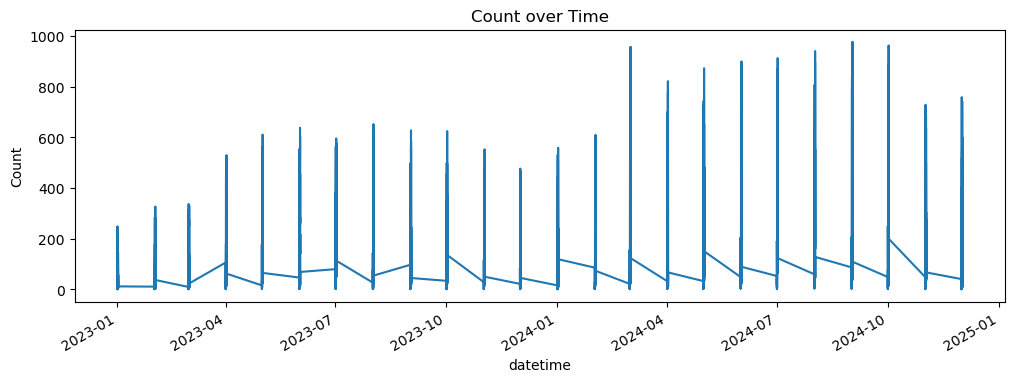

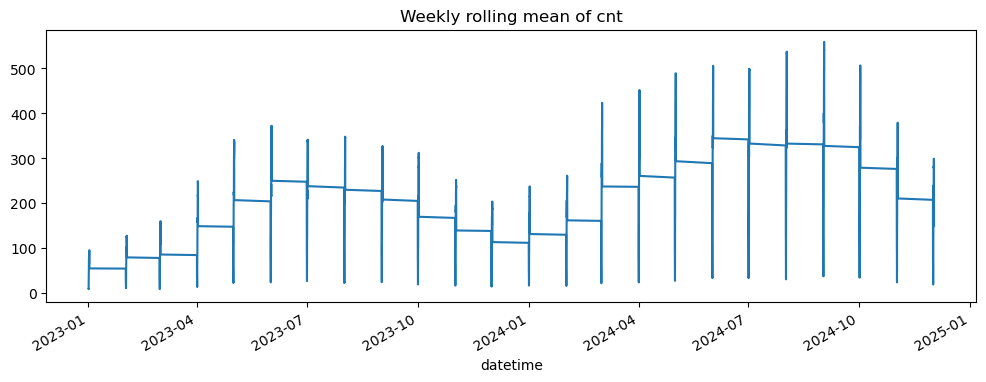

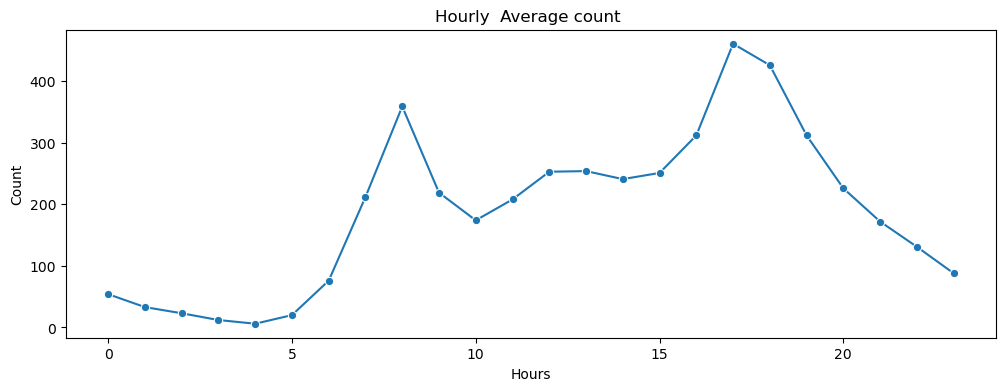

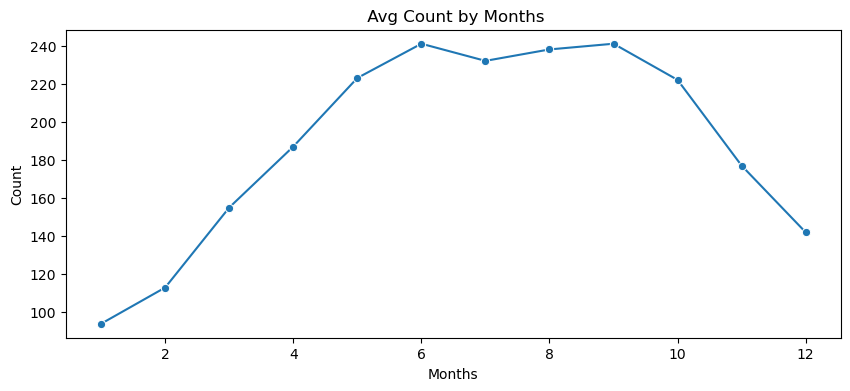

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


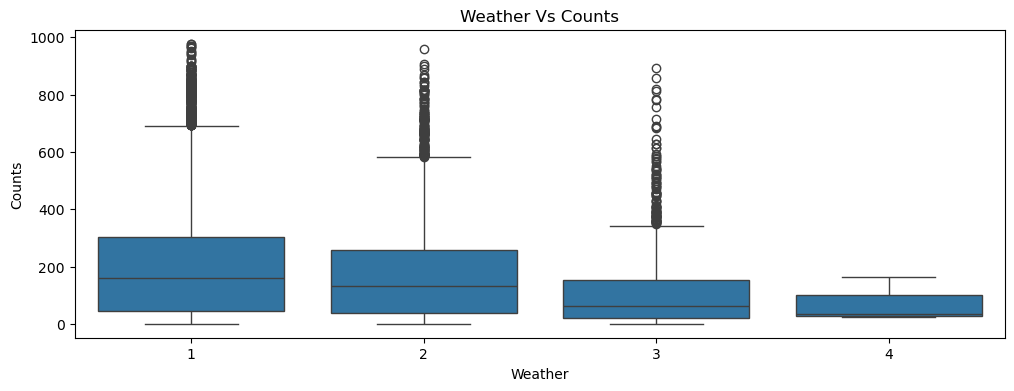

C:\Users\sahil\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.13271e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
INFO: ✅ Model training complete
INFO: 📊 Train R² Score: 0.9913 | Train MAE: 10.70
INFO: 📊Test R² Score: 0.9898 | Test MAE: 11.40
INFO: ✅ Saved object to trained_model.pkl
INFO: ✅ Saved object to scaler.pkl


In [100]:
import pandas as pd
import logging
import warnings
import json
from sklearn.model_selection import train_test_split

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
def main():
    try:
        # 1. Load and Clean Data
        df = pd.read_csv("BikeRentalData.csv")
        df , scaler = preprocess_data(df)
        logging.info("✅ Data loaded and cleaned")
        visuals(df)
        

        # 2. Split Data
        X = df.drop("cnt", axis=1)
        y = df["cnt"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 3. Train Model
        model = train_model(X_train, y_train)
        logging.info("✅ Model training complete")

        # 4. Evaluate Model
        train_r2 , mae_train = evaluate_model(model, X_train, y_train)
        r2, mae = evaluate_model(model, X_test, y_test)
        logging.info(f"📊 Train R² Score: {train_r2:.4f} | Train MAE: {mae_train:.2f}")
        logging.info(f"📊Test R² Score: {r2:.4f} | Test MAE: {mae:.2f}")

        
        # 5. Save Model
        save_object(model, "trained_model.pkl")
        save_object(scaler, "scaler.pkl")
        # Save training columns
        with open("feature_names.json", "w") as f:
            json.dump(list(X_train.columns), f)  # ✅ Correct: indented properly


    except Exception as e:
        logging.error(f"🔥 Something went wrong: {e}")
        raise

if __name__ == "__main__":
    main()